# Noisy quantum metrology: multi-qubit

In [4]:
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.base import SharedGate
from squint.ops.dv import Conditional, DiscreteVariableState, HGate, RZGate, XGate
from squint.ops.noise import BitFlipChannel
from squint.utils import print_nonzero_entries

In [5]:
dim = 2

n = 5
circuit = Circuit()
for i in range(n):
    circuit.add(DiscreteVariableState(wires=(i,), n=(0,)))

circuit.add(HGate(wires=(0,)))
for i in range(n - 1):
    circuit.add(Conditional(gate=XGate, wires=(i, i + 1)))

circuit.add(
    SharedGate(op=RZGate(wires=(0,), phi=0.1 * jnp.pi), wires=tuple(range(1, n))),
    "phase",
)

for i in range(n):
    circuit.add(HGate(wires=(i,)))


circuit.add(
    SharedGate(op=BitFlipChannel(wires=(0,), p=0.2), wires=tuple(range(1, n))),
    # SharedGate(op=DepolarizingChannel(wires=(0,), p=0.2), wires=tuple(range(1, n))),
    "noise",
)

params, static = eqx.partition(circuit, eqx.is_inexact_array)

get = lambda pytree: jnp.array([pytree.ops["phase"].op.phi])

pprint(params)
get(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(None,), n=[(None, (None,))]),
│   1:
│   DiscreteVariableState(wires=(None,), n=[(None, (None,))]),
│   2:
│   DiscreteVariableState(wires=(None,), n=[(None, (None,))]),
│   3:
│   DiscreteVariableState(wires=(None,), n=[(None, (None,))]),
│   4:
│   DiscreteVariableState(wires=(None,), n=[(None, (None,))]),
│   5:
│   HGate(wires=(None,)),
│   6:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   7:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   8:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   9:
│   Conditional(wires=(None, None), gate=XGate(wires=(None,))),
│   'phase':
│   SharedGate(
│     wires=(None, None, None, None, None),
│     op=RZGate(wires=(None,), phi=weak_f64[]),
│     copies=[
│   │   RZGate(wires=(None,), phi=None),
│   │   RZGate(wires=(None,), phi=None),
│   │   RZGate(wires=(None,), phi=None),
│   │   RZGate(wires=(None,), phi=None)
│     ],
│     where=None,
│     get=None
│   ),
│   11:
│   HGate(wires=(None,)),
│   12:
│   HGate(wires=(None,)),
│   13:
│   HGate(wires=(None,)),
│   14:
│   HGate(wires=(None,)),
│   15:
│   HGate(wires=(None,)),
│   'noise':
│   SharedGate(
│     wires=(None, None, None, None, None),
│     op=BitFlipChannel(wires=(None,), p=weak_f64[]),
│     copies=[
│   │   BitFlipChannel(wires=(None,), p=None),
│   │   BitFlipChannel(wires=(None,), p=None),
│   │   BitFlipChannel(wires=(None,), p=None),
│   │   BitFlipChannel(wires=(None,), p=None)
│     ],
│     where=None,
│     get=None
│   )
  },
  _backend=None
)

Array([0.31415927], dtype=float64)

In [6]:
path = circuit.path(dim=dim)

sim = circuit.compile(params, static, dim=2).jit()
print_nonzero_entries(sim.probabilities.forward(params))
print(sim.probabilities.cfim(get, params))

Basis: [0 0 0 0 0], Value: 0.040351442992687225
Basis: [0 0 0 0 1], Value: 0.022148562595248222
Basis: [0 0 0 1 0], Value: 0.022148562595248222
Basis: [0 0 0 1 1], Value: 0.040351442992687225
Basis: [0 0 1 0 0], Value: 0.040351442992687225
Basis: [0 0 1 0 1], Value: 0.022148562595248222
Basis: [0 0 1 1 0], Value: 0.022148562595248222
Basis: [0 0 1 1 1], Value: 0.040351442992687225
Basis: [0 1 0 0 0], Value: 0.040351442992687225
Basis: [0 1 0 0 1], Value: 0.022148562595248222
Basis: [0 1 0 1 0], Value: 0.022148562595248222
Basis: [0 1 0 1 1], Value: 0.040351442992687225
Basis: [0 1 1 0 0], Value: 0.040351442992687225
Basis: [0 1 1 0 1], Value: 0.022148562595248222
Basis: [0 1 1 1 0], Value: 0.022148562595248222
Basis: [0 1 1 1 1], Value: 0.040351442992687225
Basis: [1 0 0 0 0], Value: 0.040351442992687225
Basis: [1 0 0 0 1], Value: 0.022148562595248222
Basis: [1 0 0 1 0], Value: 0.022148562595248222
Basis: [1 0 0 1 1], Value: 0.040351442992687225
Basis: [1 0 1 0 0], Value: 0.04035144299

In [7]:
params = eqx.tree_at(lambda pytree: pytree.ops["noise"].op.p, params, 0.1)
print(sim.probabilities.cfim(get, params))

[[0.7733885]]


In [12]:
# ps = jnp.linspace(0, 0.5, 50)
ps = jnp.logspace(-10, jnp.log10(0.05), 50)

params = eqx.tree_at(lambda pytree: pytree.ops["noise"].op.p, params, ps)
params = eqx.tree_at(
    lambda pytree: pytree.ops["phase"].op.phi, params, jnp.ones_like(ps) * 0.01
)

probs = eqx.filter_vmap(sim.probabilities.forward)(params)
cfims = eqx.filter_vmap(sim.probabilities.cfim, in_axes=(None, 0))(get, params)

[Text(0.5, 0, 'Noise coefficient, $p$'),
 Text(0, 0.5, '$\\mathcal{I}_\\varphi^C$'),
 None]

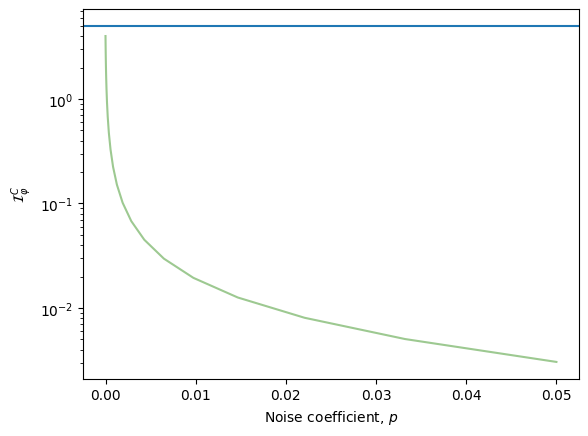

In [13]:
colors = sns.color_palette("crest", n_colors=jnp.prod(jnp.array(probs.shape[1:])))

fig, ax = plt.subplots()
ax.plot(ps, cfims.squeeze(), color=colors[0])
ax.axhline(n)
ax.set(
    # xlabel=r"Phase, $\varphi$",
    xlabel=r"Noise coefficient, $p$",
    ylabel=r"$\mathcal{I}_\varphi^C$",
    # ylim=[0, 1.05 * jnp.max(cfims)],
    yscale="log",
)